In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 1024
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
76157,"[醫, 師, ：, 他, 有, 在, 騎, 腳, 踏, 車]","[O, O, O, O, O, O, O, O, O, O]"
76158,"[民, 眾, ：, 恩]","[O, O, O, O]"
76159,"[醫, 師, ：, 騎, 腳, 踏, 車, 可, 以]","[O, O, O, O, O, O, O, O, O]"
76160,"[小, 美]","[B-name, I-name]"


In [10]:
df['x'] = df['x'].apply(lambda row : str(row))
df['y'] = df['y'].apply(lambda row : str(row))
df = df.drop_duplicates()
df['x'] = df['x'].apply(lambda row : eval(row))
df['y'] = df['y'].apply(lambda row : eval(row))
df

/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
75713,"[醫, 師, ：, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID]"
75714,"[醫, 師, ：, 6, 6, 6, 0, 8, 9, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."
75716,"[護, 理, 師, ：, 6, 6, 6, 0, 9, 8]","[O, O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID]"
75717,"[醫, 師, ：, 0, 9, 8, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."


In [11]:
x = df['x'].to_list()
y = df['y'].to_list()

In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

20172 20172
5044 5044
6305 6305


In [13]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-15 15:26:38,833 [DEBUG] kashgari - ------------------------------------------------
2020-12-15 15:26:38,834 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-15 15:26:38,834 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-15 15:26:38,835 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-15 15:26:38,835 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-15 15:26:38,836 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/1024
19/19 [==============================] - 18s 933ms/step - loss: 4.4436 - accuracy: 0.8508 - val_loss: 29.2580 - val_accuracy: 0.9693
Epoch 2/1024
19/19 [==============================] - 13s 705ms/step - loss: 1.2681 - accuracy: 0.9664 - val_loss: 29.1579 - val_accuracy: 0.9707
Epoch 3/1024
19/19 [==============================] - 13s 700ms/step - loss: 0.8948 - accuracy: 0.9694 - val_loss: 29.1220 - val_accuracy: 0.9723
Epoch 4/1024
19/19 [==============================] - 13s 700ms/step - loss: 0.7105 - accuracy: 0.9736 - val_loss: 29.1860 - val_accuracy: 0.9753
Epoch 5/1024
19/19 [==============================] - 13s 703ms/step - loss: 0.6068 - accuracy: 0.9758 - val_loss: 28.9306 - val_accuracy: 0.9761
Epoch 6/1024
19/19 [==============================] - 13s 701ms/step - loss: 0.5324 - accuracy: 0.9774 - val_loss: 28.9663 - val_accuracy: 0.9784
Epoch 7/1024
19/19 [==============================] - 13s 704ms/step - loss: 0.4806 - accuracy: 0.9782 - val_loss: 28.8168 -

Epoch 57/1024
19/19 [==============================] - 13s 710ms/step - loss: 0.0606 - accuracy: 0.9966 - val_loss: 27.8947 - val_accuracy: 0.9820
Epoch 58/1024
19/19 [==============================] - 14s 711ms/step - loss: 0.0613 - accuracy: 0.9963 - val_loss: 27.8141 - val_accuracy: 0.9844
Epoch 59/1024
19/19 [==============================] - 14s 711ms/step - loss: 0.0602 - accuracy: 0.9965 - val_loss: 27.9176 - val_accuracy: 0.9828
Epoch 60/1024
19/19 [==============================] - 14s 711ms/step - loss: 0.0576 - accuracy: 0.9967 - val_loss: 27.8348 - val_accuracy: 0.9841
Epoch 61/1024
19/19 [==============================] - 14s 722ms/step - loss: 0.0551 - accuracy: 0.9969 - val_loss: 27.9861 - val_accuracy: 0.9839
Epoch 62/1024
19/19 [==============================] - 14s 718ms/step - loss: 0.0533 - accuracy: 0.9968 - val_loss: 27.9189 - val_accuracy: 0.9827
Epoch 63/1024
19/19 [==============================] - 13s 709ms/step - loss: 0.0499 - accuracy: 0.9972 - val_loss: 27

19/19 [==============================] - 13s 708ms/step - loss: 0.0156 - accuracy: 0.9989 - val_loss: 26.8411 - val_accuracy: 0.9814
Epoch 168/1024
19/19 [==============================] - 13s 708ms/step - loss: 0.0159 - accuracy: 0.9988 - val_loss: 26.7619 - val_accuracy: 0.9809
Epoch 169/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0165 - accuracy: 0.9989 - val_loss: 26.7501 - val_accuracy: 0.9791
Epoch 170/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0146 - accuracy: 0.9989 - val_loss: 26.7182 - val_accuracy: 0.9797
Epoch 171/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0162 - accuracy: 0.9987 - val_loss: 26.8211 - val_accuracy: 0.9807
Epoch 172/1024
19/19 [==============================] - 14s 725ms/step - loss: 0.0150 - accuracy: 0.9989 - val_loss: 26.7671 - val_accuracy: 0.9813
Epoch 173/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0146 - accuracy: 0.9989 - val_loss: 26.8379 - 

19/19 [==============================] - 13s 706ms/step - loss: 0.0101 - accuracy: 0.9990 - val_loss: 25.8693 - val_accuracy: 0.9726
Epoch 278/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0111 - accuracy: 0.9989 - val_loss: 25.8517 - val_accuracy: 0.9730
Epoch 279/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0100 - accuracy: 0.9990 - val_loss: 25.8408 - val_accuracy: 0.9754
Epoch 280/1024
19/19 [==============================] - 13s 708ms/step - loss: 0.0094 - accuracy: 0.9991 - val_loss: 25.8854 - val_accuracy: 0.9756
Epoch 281/1024
19/19 [==============================] - 14s 717ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 25.8579 - val_accuracy: 0.9756
Epoch 282/1024
19/19 [==============================] - 14s 717ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 25.8562 - val_accuracy: 0.9773
Epoch 283/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0102 - accuracy: 0.9990 - val_loss: 25.7578 - 

19/19 [==============================] - 13s 708ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 24.5070 - val_accuracy: 0.9390
Epoch 388/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 24.4395 - val_accuracy: 0.9061
Epoch 389/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 24.3891 - val_accuracy: 0.9027
Epoch 390/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 24.4187 - val_accuracy: 0.7837
Epoch 391/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 24.4537 - val_accuracy: 0.7832
Epoch 392/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0075 - accuracy: 0.9991 - val_loss: 24.4704 - val_accuracy: 0.7860
Epoch 393/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 24.4406 - 

19/19 [==============================] - 13s 705ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 23.1613 - val_accuracy: 0.0531
Epoch 498/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 23.0820 - val_accuracy: 0.0521
Epoch 499/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 23.0610 - val_accuracy: 0.0511
Epoch 500/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 23.0826 - val_accuracy: 0.0495
Epoch 501/1024
19/19 [==============================] - 14s 714ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 23.0514 - val_accuracy: 0.0556
Epoch 502/1024
19/19 [==============================] - 14s 715ms/step - loss: 0.0080 - accuracy: 0.9988 - val_loss: 22.9852 - val_accuracy: 0.0504
Epoch 503/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 23.0904 - 

19/19 [==============================] - 13s 706ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 21.8386 - val_accuracy: 0.0250
Epoch 608/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 21.8235 - val_accuracy: 0.0265
Epoch 609/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 21.8794 - val_accuracy: 0.0250
Epoch 610/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0060 - accuracy: 0.9991 - val_loss: 21.7204 - val_accuracy: 0.0267
Epoch 611/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 21.9088 - val_accuracy: 0.0261
Epoch 612/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 21.8389 - val_accuracy: 0.0270
Epoch 613/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 21.7932 - 

19/19 [==============================] - 13s 706ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 20.9651 - val_accuracy: 0.0202
Epoch 718/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 20.9436 - val_accuracy: 0.0204
Epoch 719/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 20.8829 - val_accuracy: 0.0178
Epoch 720/1024
19/19 [==============================] - 13s 705ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 20.9548 - val_accuracy: 0.0183
Epoch 721/1024
19/19 [==============================] - 14s 717ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 20.9149 - val_accuracy: 0.0198
Epoch 722/1024
19/19 [==============================] - 14s 716ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 20.8945 - val_accuracy: 0.0216
Epoch 723/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 20.8795 - 

19/19 [==============================] - 13s 709ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 20.1174 - val_accuracy: 0.0154
Epoch 828/1024
19/19 [==============================] - 13s 708ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 20.1654 - val_accuracy: 0.0152
Epoch 829/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 20.1622 - val_accuracy: 0.0151
Epoch 830/1024
19/19 [==============================] - 13s 709ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 20.2011 - val_accuracy: 0.0172
Epoch 831/1024
19/19 [==============================] - 13s 709ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 20.1282 - val_accuracy: 0.0161
Epoch 832/1024
19/19 [==============================] - 13s 706ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 20.1698 - val_accuracy: 0.0154
Epoch 833/1024
19/19 [==============================] - 13s 707ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 20.1383 - 

19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 19.6273 - val_accuracy: 0.0123
Epoch 938/1024
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 19.6973 - val_accuracy: 0.0113
Epoch 939/1024
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 19.7130 - val_accuracy: 0.0122
Epoch 940/1024
19/19 [==============================] - 13s 704ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 19.6775 - val_accuracy: 0.0125
Epoch 941/1024
19/19 [==============================] - 14s 713ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 19.7405 - val_accuracy: 0.0116
Epoch 942/1024
19/19 [==============================] - 14s 712ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 19.6479 - val_accuracy: 0.0115
Epoch 943/1024
19/19 [==============================] - 14s 726ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 19.6324 - 

In [14]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-15 19:26:59,624 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 102
2020-12-15 19:26:59,676 [DEBUG] kashgari - predict seq_length: None, input: (2, 6305, 102)


198/198 [==============================] - 26s 131ms/step


2020-12-15 19:27:29,827 [DEBUG] kashgari - predict output: (6305, 102)
2020-12-15 19:27:29,828 [DEBUG] kashgari - predict output argmax: [[0 3 2 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



              precision    recall  f1-score   support

        time     0.6970    0.7481    0.7217       532
    location     0.8000    0.9167    0.8544        48
    med_exam     0.7170    0.7677    0.7415        99
        name     0.7778    0.9333    0.8485        45
       money     0.5500    0.5500    0.5500        20
      family     0.3333    0.3750    0.3529         8
          ID     0.1667    0.2500    0.2000         4
  profession     1.0000    0.6667    0.8000         3
     contact     0.5000    0.2500    0.3333        12
organization     1.0000    1.0000    1.0000         1
   education     0.0000    0.0000    0.0000         2
      others     1.0000    1.0000    1.0000         1

   micro avg     0.7004    0.7510    0.7248       775
   macro avg     0.6975    0.7510    0.7220       775



2020-12-15 19:28:41,371 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_1024_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_1024_batch_1024'

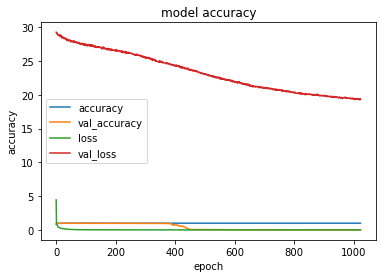

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [16]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [17]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [18]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [19]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-15 19:28:41,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 23ms/step


2020-12-15 19:28:45,807 [DEBUG] kashgari - predict output: (70, 17)
2020-12-15 19:28:45,807 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:28:45,810 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-15 19:28:49,839 [DEBUG] kashgari - predict output: (131, 28)
2020-12-15 19:28:49,840 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:28:49,844 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 61ms/step


2020-12-15 19:28:53,956 [DEBUG] kashgari - predict output: (198, 47)
2020-12-15 19:28:53,957 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 19:28:53,960 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 37ms/step


2020-12-15 19:28:56,655 [DEBUG] kashgari - predict output: (96, 41)
2020-12-15 19:28:56,656 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:28:56,659 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 23ms/step


2020-12-15 19:28:56,790 [DEBUG] kashgari - predict output: (73, 17)
2020-12-15 19:28:56,791 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:28:56,797 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 41ms/step


2020-12-15 19:29:00,835 [DEBUG] kashgari - predict output: (266, 23)
2020-12-15 19:29:00,836 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 19:29:00,840 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 35ms/step


2020-12-15 19:29:04,862 [DEBUG] kashgari - predict output: (308, 21)
2020-12-15 19:29:04,863 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:04,867 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 44ms/step


2020-12-15 19:29:08,797 [DEBUG] kashgari - predict output: (139, 38)
2020-12-15 19:29:08,798 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:08,801 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-15 19:29:13,631 [DEBUG] kashgari - predict output: (167, 22)
2020-12-15 19:29:13,632 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:13,638 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 54ms/step


2020-12-15 19:29:17,846 [DEBUG] kashgari - predict output: (272, 41)
2020-12-15 19:29:17,847 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:17,850 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 68ms/step


2020-12-15 19:29:21,938 [DEBUG] kashgari - predict output: (143, 63)
2020-12-15 19:29:21,939 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:21,945 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 57ms/step


2020-12-15 19:29:26,895 [DEBUG] kashgari - predict output: (663, 42)
2020-12-15 19:29:26,896 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:26,899 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 17ms/step


2020-12-15 19:29:30,635 [DEBUG] kashgari - predict output: (39, 25)
2020-12-15 19:29:30,639 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 35ms/step


2020-12-15 19:29:30,922 [DEBUG] kashgari - predict output: (175, 22)
2020-12-15 19:29:30,923 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:30,927 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-15 19:29:31,199 [DEBUG] kashgari - predict output: (143, 28)
2020-12-15 19:29:31,200 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:31,203 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-15 19:29:31,341 [DEBUG] kashgari - predict output: (88, 21)
2020-12-15 19:29:31,342 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:31,346 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 33ms/step


2020-12-15 19:29:31,549 [DEBUG] kashgari - predict output: (121, 28)
2020-12-15 19:29:31,550 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:31,553 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 30ms/step


2020-12-15 19:29:35,381 [DEBUG] kashgari - predict output: (85, 27)
2020-12-15 19:29:35,382 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:35,388 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 34ms/step


2020-12-15 19:29:39,335 [DEBUG] kashgari - predict output: (255, 19)
2020-12-15 19:29:39,336 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:39,339 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 41ms/step


2020-12-15 19:29:44,230 [DEBUG] kashgari - predict output: (202, 29)
2020-12-15 19:29:44,231 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:44,234 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 31ms/step


2020-12-15 19:29:44,516 [DEBUG] kashgari - predict output: (198, 19)
2020-12-15 19:29:44,517 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 6 6 6]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:44,520 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 41ms/step


2020-12-15 19:29:48,414 [DEBUG] kashgari - predict output: (102, 39)
2020-12-15 19:29:48,415 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:48,417 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 32ms/step


2020-12-15 19:29:52,227 [DEBUG] kashgari - predict output: (72, 36)
2020-12-15 19:29:52,228 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:52,234 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 41ms/step


2020-12-15 19:29:52,636 [DEBUG] kashgari - predict output: (246, 27)
2020-12-15 19:29:52,637 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:52,639 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-15 19:29:56,594 [DEBUG] kashgari - predict output: (57, 34)
2020-12-15 19:29:56,595 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:56,598 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:29:56,748 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 19:29:56,749 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:29:56,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 43ms/step


2020-12-15 19:30:00,703 [DEBUG] kashgari - predict output: (185, 32)
2020-12-15 19:30:00,704 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:00,706 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 34ms/step


2020-12-15 19:30:00,944 [DEBUG] kashgari - predict output: (148, 28)
2020-12-15 19:30:00,945 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:00,949 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 38ms/step


2020-12-15 19:30:01,358 [DEBUG] kashgari - predict output: (281, 23)
2020-12-15 19:30:01,359 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:01,361 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 29ms/step


2020-12-15 19:30:05,183 [DEBUG] kashgari - predict output: (116, 20)
2020-12-15 19:30:05,184 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:05,187 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-15 19:30:05,490 [DEBUG] kashgari - predict output: (168, 25)
2020-12-15 19:30:05,491 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:05,497 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 42ms/step


2020-12-15 19:30:09,524 [DEBUG] kashgari - predict output: (218, 30)
2020-12-15 19:30:09,525 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:09,528 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 34ms/step


2020-12-15 19:30:09,737 [DEBUG] kashgari - predict output: (123, 32)
2020-12-15 19:30:09,738 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:09,740 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 22ms/step


2020-12-15 19:30:09,865 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 19:30:09,866 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:09,868 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 23ms/step


2020-12-15 19:30:10,003 [DEBUG] kashgari - predict output: (95, 19)
2020-12-15 19:30:10,004 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:10,008 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 39ms/step


2020-12-15 19:30:14,108 [DEBUG] kashgari - predict output: (245, 24)
2020-12-15 19:30:14,109 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 17 11 ...  5  5  5]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 19:30:14,111 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 40ms/step


2020-12-15 19:30:17,971 [DEBUG] kashgari - predict output: (126, 31)
2020-12-15 19:30:17,972 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:17,974 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 15ms/step


2020-12-15 19:30:21,698 [DEBUG] kashgari - predict output: (64, 19)
2020-12-15 19:30:21,699 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:21,702 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 30ms/step


2020-12-15 19:30:21,867 [DEBUG] kashgari - predict output: (93, 24)
2020-12-15 19:30:21,868 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:21,872 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 33ms/step


2020-12-15 19:30:25,771 [DEBUG] kashgari - predict output: (214, 16)
2020-12-15 19:30:25,772 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:25,775 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 17ms/step


2020-12-15 19:30:25,875 [DEBUG] kashgari - predict output: (53, 20)
2020-12-15 19:30:25,876 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:25,884 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 26ms/step


2020-12-15 19:30:28,802 [DEBUG] kashgari - predict output: (384, 18)
2020-12-15 19:30:28,803 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:28,806 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 33ms/step


2020-12-15 19:30:29,075 [DEBUG] kashgari - predict output: (172, 24)
2020-12-15 19:30:29,076 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:29,078 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 30ms/step


2020-12-15 19:30:29,263 [DEBUG] kashgari - predict output: (114, 24)
2020-12-15 19:30:29,263 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:29,267 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 49ms/step


2020-12-15 19:30:29,561 [DEBUG] kashgari - predict output: (111, 47)
2020-12-15 19:30:29,562 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:29,567 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 47ms/step


2020-12-15 19:30:30,159 [DEBUG] kashgari - predict output: (350, 34)
2020-12-15 19:30:30,160 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:30,163 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 18ms/step


2020-12-15 19:30:30,263 [DEBUG] kashgari - predict output: (56, 20)
2020-12-15 19:30:30,264 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:30,268 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 26ms/step


2020-12-15 19:30:30,460 [DEBUG] kashgari - predict output: (131, 17)
2020-12-15 19:30:30,461 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:30,465 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 43ms/step


2020-12-15 19:30:30,802 [DEBUG] kashgari - predict output: (184, 34)
2020-12-15 19:30:30,803 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:30,806 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 56ms/step


2020-12-15 19:30:34,836 [DEBUG] kashgari - predict output: (133, 51)
2020-12-15 19:30:34,838 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:34,841 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 62ms/step


2020-12-15 19:30:39,026 [DEBUG] kashgari - predict output: (210, 53)
2020-12-15 19:30:39,027 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:39,030 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 64ms/step


2020-12-15 19:30:43,238 [DEBUG] kashgari - predict output: (193, 55)
2020-12-15 19:30:43,239 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  9  5 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 19:30:43,241 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:30:43,394 [DEBUG] kashgari - predict output: (75, 30)
2020-12-15 19:30:43,395 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:43,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 61ms/step


2020-12-15 19:30:47,691 [DEBUG] kashgari - predict output: (280, 46)
2020-12-15 19:30:47,692 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:47,695 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 30ms/step


2020-12-15 19:30:47,970 [DEBUG] kashgari - predict output: (210, 20)
2020-12-15 19:30:47,971 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:47,974 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 34ms/step


2020-12-15 19:30:48,246 [DEBUG] kashgari - predict output: (176, 24)
2020-12-15 19:30:48,248 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:48,252 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 37ms/step


2020-12-15 19:30:48,582 [DEBUG] kashgari - predict output: (218, 25)
2020-12-15 19:30:48,583 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:48,585 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:30:48,735 [DEBUG] kashgari - predict output: (91, 23)
2020-12-15 19:30:48,736 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:48,740 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 35ms/step


2020-12-15 19:30:49,058 [DEBUG] kashgari - predict output: (194, 28)
2020-12-15 19:30:49,059 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:49,062 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 33ms/step


2020-12-15 19:30:49,331 [DEBUG] kashgari - predict output: (179, 23)
2020-12-15 19:30:49,332 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:49,337 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 50ms/step


2020-12-15 19:30:53,435 [DEBUG] kashgari - predict output: (234, 40)
2020-12-15 19:30:53,437 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:53,440 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 38ms/step


2020-12-15 19:30:57,431 [DEBUG] kashgari - predict output: (250, 26)
2020-12-15 19:30:57,432 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:30:57,436 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 48ms/step


2020-12-15 19:31:01,413 [DEBUG] kashgari - predict output: (170, 43)
2020-12-15 19:31:01,414 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:01,417 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 38ms/step


2020-12-15 19:31:01,684 [DEBUG] kashgari - predict output: (145, 34)
2020-12-15 19:31:01,685 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:01,688 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 32ms/step


2020-12-15 19:31:01,887 [DEBUG] kashgari - predict output: (102, 29)
2020-12-15 19:31:01,888 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:01,893 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 33ms/step


2020-12-15 19:31:02,326 [DEBUG] kashgari - predict output: (340, 20)
2020-12-15 19:31:02,327 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:02,331 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 31ms/step


2020-12-15 19:31:02,527 [DEBUG] kashgari - predict output: (122, 23)
2020-12-15 19:31:02,528 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:02,534 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 0s 41ms/step


2020-12-15 19:31:03,097 [DEBUG] kashgari - predict output: (381, 28)
2020-12-15 19:31:03,098 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:03,103 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 37ms/step


2020-12-15 19:31:03,481 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 19:31:03,482 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:03,484 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 43ms/step


2020-12-15 19:31:03,707 [DEBUG] kashgari - predict output: (91, 46)
2020-12-15 19:31:03,709 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:03,712 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 51ms/step


2020-12-15 19:31:04,160 [DEBUG] kashgari - predict output: (223, 42)
2020-12-15 19:31:04,161 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:04,165 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 34ms/step


2020-12-15 19:31:04,404 [DEBUG] kashgari - predict output: (146, 25)
2020-12-15 19:31:04,405 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:04,409 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 33ms/step


2020-12-15 19:31:04,676 [DEBUG] kashgari - predict output: (162, 23)
2020-12-15 19:31:04,676 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:04,681 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 38ms/step


2020-12-15 19:31:05,053 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 19:31:05,054 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:05,058 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 31ms/step


2020-12-15 19:31:08,891 [DEBUG] kashgari - predict output: (170, 18)
2020-12-15 19:31:08,891 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:08,895 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 47ms/step


2020-12-15 19:31:09,313 [DEBUG] kashgari - predict output: (199, 36)
2020-12-15 19:31:09,314 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:09,322 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 33ms/step


2020-12-15 19:31:09,985 [DEBUG] kashgari - predict output: (557, 17)
2020-12-15 19:31:09,986 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:09,989 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 52ms/step


2020-12-15 19:31:10,558 [DEBUG] kashgari - predict output: (278, 42)
2020-12-15 19:31:10,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:10,563 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-15 19:31:10,705 [DEBUG] kashgari - predict output: (91, 19)
2020-12-15 19:31:10,706 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:10,713 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 37ms/step


2020-12-15 19:31:11,149 [DEBUG] kashgari - predict output: (296, 24)
2020-12-15 19:31:11,150 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:11,153 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 58ms/step


2020-12-15 19:31:15,204 [DEBUG] kashgari - predict output: (154, 48)
2020-12-15 19:31:15,205 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:15,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 52ms/step


2020-12-15 19:31:20,879 [DEBUG] kashgari - predict output: (206, 37)
2020-12-15 19:31:20,880 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:20,884 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 32ms/step


2020-12-15 19:31:21,207 [DEBUG] kashgari - predict output: (241, 20)
2020-12-15 19:31:21,208 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:21,215 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 46ms/step


2020-12-15 19:31:21,991 [DEBUG] kashgari - predict output: (459, 31)
2020-12-15 19:31:21,992 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:21,996 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 45ms/step


2020-12-15 19:31:22,395 [DEBUG] kashgari - predict output: (223, 34)
2020-12-15 19:31:22,396 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:22,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 40ms/step


2020-12-15 19:31:22,964 [DEBUG] kashgari - predict output: (358, 26)
2020-12-15 19:31:22,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:22,968 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 24ms/step


2020-12-15 19:31:23,100 [DEBUG] kashgari - predict output: (72, 20)
2020-12-15 19:31:23,101 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:23,104 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 25ms/step


2020-12-15 19:31:23,250 [DEBUG] kashgari - predict output: (75, 24)
2020-12-15 19:31:23,251 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:23,255 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 45ms/step


2020-12-15 19:31:23,607 [DEBUG] kashgari - predict output: (191, 36)
2020-12-15 19:31:23,607 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:23,610 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 30ms/step


2020-12-15 19:31:23,824 [DEBUG] kashgari - predict output: (149, 19)
2020-12-15 19:31:23,825 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:23,829 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-15 19:31:24,089 [DEBUG] kashgari - predict output: (176, 22)
2020-12-15 19:31:24,090 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:24,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 51ms/step


2020-12-15 19:31:27,975 [DEBUG] kashgari - predict output: (112, 45)
2020-12-15 19:31:27,976 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:27,980 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 36ms/step


2020-12-15 19:31:28,376 [DEBUG] kashgari - predict output: (269, 21)
2020-12-15 19:31:28,377 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:28,381 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 26ms/step


2020-12-15 19:31:28,554 [DEBUG] kashgari - predict output: (112, 18)
2020-12-15 19:31:28,555 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 7 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:28,562 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 30ms/step


2020-12-15 19:31:31,707 [DEBUG] kashgari - predict output: (352, 22)
2020-12-15 19:31:31,708 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:31,712 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 36ms/step


2020-12-15 19:31:32,071 [DEBUG] kashgari - predict output: (243, 24)
2020-12-15 19:31:32,072 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:32,078 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 40ms/step


2020-12-15 19:31:32,601 [DEBUG] kashgari - predict output: (340, 27)
2020-12-15 19:31:32,602 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:32,606 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 33ms/step


2020-12-15 19:31:35,607 [DEBUG] kashgari - predict output: (384, 25)
2020-12-15 19:31:35,608 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:35,611 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 38ms/step


2020-12-15 19:31:35,845 [DEBUG] kashgari - predict output: (112, 36)
2020-12-15 19:31:35,846 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:35,850 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 38ms/step


2020-12-15 19:31:36,192 [DEBUG] kashgari - predict output: (222, 28)
2020-12-15 19:31:36,193 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:36,197 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 47ms/step


2020-12-15 19:31:36,654 [DEBUG] kashgari - predict output: (255, 34)
2020-12-15 19:31:36,654 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:36,657 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:31:36,808 [DEBUG] kashgari - predict output: (67, 25)
2020-12-15 19:31:36,809 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:36,812 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 44ms/step


2020-12-15 19:31:37,048 [DEBUG] kashgari - predict output: (77, 53)
2020-12-15 19:31:37,049 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:37,051 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:31:37,200 [DEBUG] kashgari - predict output: (67, 27)
2020-12-15 19:31:37,201 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:37,205 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 23ms/step


2020-12-15 19:31:37,337 [DEBUG] kashgari - predict output: (72, 19)
2020-12-15 19:31:37,338 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:37,342 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 28ms/step


2020-12-15 19:31:37,521 [DEBUG] kashgari - predict output: (98, 24)
2020-12-15 19:31:37,522 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:37,526 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 35ms/step


2020-12-15 19:31:37,714 [DEBUG] kashgari - predict output: (87, 37)
2020-12-15 19:31:37,715 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:37,720 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 42ms/step


2020-12-15 19:31:38,214 [DEBUG] kashgari - predict output: (311, 29)
2020-12-15 19:31:38,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:38,220 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 0s 35ms/step


2020-12-15 19:31:38,769 [DEBUG] kashgari - predict output: (447, 20)
2020-12-15 19:31:38,770 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:38,774 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 32ms/step


2020-12-15 19:31:39,072 [DEBUG] kashgari - predict output: (218, 19)
2020-12-15 19:31:39,073 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:39,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 42ms/step


2020-12-15 19:31:39,536 [DEBUG] kashgari - predict output: (285, 30)
2020-12-15 19:31:39,537 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:39,542 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 0s 34ms/step


2020-12-15 19:31:40,081 [DEBUG] kashgari - predict output: (424, 21)
2020-12-15 19:31:40,082 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:40,084 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 30ms/step


2020-12-15 19:31:40,240 [DEBUG] kashgari - predict output: (94, 30)
2020-12-15 19:31:40,241 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:40,245 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 42ms/step


2020-12-15 19:31:40,618 [DEBUG] kashgari - predict output: (202, 34)
2020-12-15 19:31:40,619 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:40,622 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 1s 64ms/step


2020-12-15 19:31:44,870 [DEBUG] kashgari - predict output: (242, 50)
2020-12-15 19:31:44,871 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 19:31:44,874 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 49ms/step


2020-12-15 19:31:45,399 [DEBUG] kashgari - predict output: (269, 38)
2020-12-15 19:31:45,400 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:45,404 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 40ms/step


2020-12-15 19:31:49,407 [DEBUG] kashgari - predict output: (108, 35)
2020-12-15 19:31:49,408 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:49,411 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 39ms/step


2020-12-15 19:31:49,689 [DEBUG] kashgari - predict output: (136, 30)
2020-12-15 19:31:49,690 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:49,694 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 40ms/step


2020-12-15 19:31:50,053 [DEBUG] kashgari - predict output: (217, 28)
2020-12-15 19:31:50,054 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:50,056 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-15 19:31:50,208 [DEBUG] kashgari - predict output: (83, 27)
2020-12-15 19:31:50,209 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:50,215 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 48ms/step


2020-12-15 19:31:50,930 [DEBUG] kashgari - predict output: (392, 36)
2020-12-15 19:31:50,931 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:50,934 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 41ms/step


2020-12-15 19:31:51,183 [DEBUG] kashgari - predict output: (108, 41)
2020-12-15 19:31:51,184 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:51,189 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 37ms/step


2020-12-15 19:31:51,525 [DEBUG] kashgari - predict output: (221, 26)
2020-12-15 19:31:51,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:51,528 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 43ms/step


2020-12-15 19:31:51,754 [DEBUG] kashgari - predict output: (94, 45)
2020-12-15 19:31:51,755 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:51,757 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 19ms/step


2020-12-15 19:31:51,853 [DEBUG] kashgari - predict output: (59, 21)
2020-12-15 19:31:51,854 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:51,857 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 36ms/step


2020-12-15 19:31:55,690 [DEBUG] kashgari - predict output: (101, 33)
2020-12-15 19:31:55,691 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:55,694 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 23ms/step


2020-12-15 19:31:58,344 [DEBUG] kashgari - predict output: (64, 33)
2020-12-15 19:31:58,345 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:58,347 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 34ms/step


2020-12-15 19:31:58,534 [DEBUG] kashgari - predict output: (85, 30)
2020-12-15 19:31:58,535 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:58,538 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 35ms/step


2020-12-15 19:31:58,731 [DEBUG] kashgari - predict output: (89, 33)
2020-12-15 19:31:58,732 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:58,737 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 19:31:59,134 [DEBUG] kashgari - predict output: (254, 27)
2020-12-15 19:31:59,135 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:59,139 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 35ms/step


2020-12-15 19:31:59,389 [DEBUG] kashgari - predict output: (129, 29)
2020-12-15 19:31:59,390 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:59,394 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 33ms/step


2020-12-15 19:31:59,630 [DEBUG] kashgari - predict output: (130, 26)
2020-12-15 19:31:59,631 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:59,636 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 42ms/step


2020-12-15 19:31:59,927 [DEBUG] kashgari - predict output: (143, 37)
2020-12-15 19:31:59,928 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:31:59,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 39ms/step


2020-12-15 19:32:00,167 [DEBUG] kashgari - predict output: (107, 36)
2020-12-15 19:32:00,168 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:00,170 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 26ms/step


2020-12-15 19:32:00,320 [DEBUG] kashgari - predict output: (70, 28)
2020-12-15 19:32:00,321 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:00,326 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 38ms/step


2020-12-15 19:32:00,626 [DEBUG] kashgari - predict output: (189, 26)
2020-12-15 19:32:00,627 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:00,630 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 46ms/step


2020-12-15 19:32:00,909 [DEBUG] kashgari - predict output: (99, 48)
2020-12-15 19:32:00,910 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:00,913 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 45ms/step


2020-12-15 19:32:01,310 [DEBUG] kashgari - predict output: (213, 35)
2020-12-15 19:32:01,311 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:01,314 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 47ms/step


2020-12-15 19:32:01,691 [DEBUG] kashgari - predict output: (181, 40)
2020-12-15 19:32:01,692 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:01,694 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 38ms/step


2020-12-15 19:32:01,924 [DEBUG] kashgari - predict output: (119, 34)
2020-12-15 19:32:01,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:01,929 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 65ms/step


2020-12-15 19:32:06,061 [DEBUG] kashgari - predict output: (188, 52)
2020-12-15 19:32:06,062 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:06,066 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 42ms/step


2020-12-15 19:32:06,480 [DEBUG] kashgari - predict output: (252, 30)
2020-12-15 19:32:06,481 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:06,486 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 48ms/step


2020-12-15 19:32:06,958 [DEBUG] kashgari - predict output: (249, 38)
2020-12-15 19:32:06,959 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:06,962 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 36ms/step


2020-12-15 19:32:10,753 [DEBUG] kashgari - predict output: (65, 44)
2020-12-15 19:32:10,754 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 19:32:10,759 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 0s 55ms/step


2020-12-15 19:32:11,352 [DEBUG] kashgari - predict output: (265, 41)
2020-12-15 19:32:11,353 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:11,356 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 40ms/step


2020-12-15 19:32:11,674 [DEBUG] kashgari - predict output: (163, 33)
2020-12-15 19:32:11,675 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:11,680 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 40ms/step


2020-12-15 19:32:12,002 [DEBUG] kashgari - predict output: (166, 33)
2020-12-15 19:32:12,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:12,006 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 45ms/step


2020-12-15 19:32:12,318 [DEBUG] kashgari - predict output: (152, 37)
2020-12-15 19:32:12,318 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:12,321 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 33ms/step


2020-12-15 19:32:12,558 [DEBUG] kashgari - predict output: (129, 26)
2020-12-15 19:32:12,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:12,562 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 51ms/step


2020-12-15 19:32:13,110 [DEBUG] kashgari - predict output: (260, 42)
2020-12-15 19:32:13,111 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:13,118 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 75ms/step


2020-12-15 19:32:18,192 [DEBUG] kashgari - predict output: (557, 59)
2020-12-15 19:32:18,193 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 19:32:18,197 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 73ms/step


2020-12-15 19:32:22,308 [DEBUG] kashgari - predict output: (144, 72)
2020-12-15 19:32:22,309 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:22,314 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 42ms/step


2020-12-15 19:32:23,013 [DEBUG] kashgari - predict output: (474, 27)
2020-12-15 19:32:23,014 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:23,018 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 45ms/step


2020-12-15 19:32:23,461 [DEBUG] kashgari - predict output: (253, 34)
2020-12-15 19:32:23,463 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:23,466 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 58ms/step


2020-12-15 19:32:23,971 [DEBUG] kashgari - predict output: (210, 45)
2020-12-15 19:32:23,972 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:23,976 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 44ms/step


2020-12-15 19:32:24,418 [DEBUG] kashgari - predict output: (244, 32)
2020-12-15 19:32:24,419 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:24,423 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 51ms/step


2020-12-15 19:32:25,016 [DEBUG] kashgari - predict output: (319, 36)
2020-12-15 19:32:25,017 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:25,022 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 51ms/step


2020-12-15 19:32:25,827 [DEBUG] kashgari - predict output: (437, 36)
2020-12-15 19:32:25,829 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 19:32:25,832 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 1s 85ms/step


2020-12-15 19:32:30,066 [DEBUG] kashgari - predict output: (171, 78)
2020-12-15 19:32:30,068 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [20]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [21]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,113,115,今天,time
1,0,227,229,麻豆,location
2,0,237,239,麻豆,location
3,0,295,297,今年,time
4,1,31,33,今天,time
...,...,...,...,...,...
2769,158,448,451,二十幾,med_exam
2770,158,1074,1076,今天,time
2771,158,1143,1145,今天,time
2772,158,1199,1201,小安,name
